**โครงงาน คาดการณใช้ไฟฟ้าภายในครัวเรือน**


**สมาชิก**

1. 6510210160 นายนิติภูมิ พลาสิน
2. 6510210490 นายธนยศ ฉะฉิ้น



# **1.เตรียมข้อมูล**

**ชุดข้อมูล**

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


In [163]:
#https://drive.google.com/file/d/1PwbNHlE3ZLDkfvNdPSRjVw2pccazyme-/view?usp=sharing
df = pd.read_csv('/content/household_power_consumption.csv',
                 sep=',',
                 parse_dates={'datetime': ['Date', 'Time']},
                 dayfirst=True,
                 na_values=['nan', '?'])

<ipython-input-163-04f7157e407b>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('/content/household_power_consumption.csv',


**จำนวนข้อมูล และจำนวนคุณลักษณะ (features)**


In [164]:
r,c = df.shape
print(r) #แถว
print(c) #atribute

1048575
8


In [165]:
df.size

8388600

In [166]:
df.dtypes

,0
datetime,datetime64[ns]
Global_active_power,float64
Global_reactive_power,float64
Voltage,float64
Global_intensity,float64
Sub_metering_1,float64
Sub_metering_2,float64
Sub_metering_3,float64


**อธิบายแต่ละ feature**

1.Date: วันที่ในรูปแบบวัน/เดือน/ปี (dd/mm/yyyy)

2.Time: เวลาที่บันทึกในรูปแบบชั่วโมง:นาที:วินาที (hh:mm
)

3.Global_active_power: กำลังไฟฟ้าทั้งหมดที่ใช้ในบ้าน (เฉลี่ยเป็นนาที) หน่วยเป็นกิโลวัตต์ (kW)

* กำลังไฟฟ้าทั้งหมด (Global active power) คือกำลังไฟฟ้าที่แท้จริงที่ถูกใช้โดยอุปกรณ์ไฟฟ้าในอาคารหรือระบบไฟฟ้าทั้งหมดในกริด มันวัดการใช้พลังงานจริงและแสดงผลเป็นวัตต์ (W)

4.Global_reactive_power: กำลังไฟฟ้าเชิงพาราซิติก (เฉลี่ยเป็นนาที) หน่วยเป็นกิโลวัตต์ (kW)

* กำลังไฟฟ้าเชิงพาราซิติก (Global reactive power) คือปริมาณพลังงานไฟฟ้าที่ไหลกลับไปกลับมาระหว่างแหล่งจ่ายไฟและโหลดในระบบไฟฟ้ากระแสสลับ (AC) โดยมันไม่ได้ทำงานที่มีประโยชน์ แต่มีความจำเป็นเพื่อรักษาระดับแรงดันในระบบ โดยแสดงผลเป็นวอลต์-แอมแปร์เชิงพาราซิติก (VAR)

5.Voltage: แรงดันไฟฟ้า (เฉลี่ยเป็นนาที) หน่วยเป็นโวลต์ (V)

* แรงดันไฟฟ้า (Voltage) หรือที่เรียกว่า ความต่างศักย์ไฟฟ้า คือการวัดพลังงานไฟฟ้าต่อหน่วยประจุในวงจรไฟฟ้า มันเป็นแรงที่ขับเคลื่อนการไหลของประจุไฟฟ้าในวงจรและแสดงผลเป็นโวลต์ (V)

6.Global_intensity: ความเข้มของกระแสไฟฟ้า (เฉลี่ยเป็นนาที) หน่วยเป็นแอมแปร์ (A)

* ความเข้มของกระแส (Global intensity) หมายถึงการไหลเฉลี่ยของกระแสไฟฟ้าในระบบไฟฟ้า เช่น อาคารหรือกริดไฟฟ้าทั้งหมด มันวัดปริมาณการไหลของประจุไฟฟ้าที่เคลื่อนที่ผ่านตัวนำในหน่วยเวลาและแสดงผลเป็นแอมแปร์ (A)

7.Sub_metering_1: การใช้พลังงานในหมวดหมู่ที่ 1 (หน่วยเป็นวัตต์-ชั่วโมง ของพลังงานที่ใช้งานจริง)

* การวัดนี้เกี่ยวข้องกับห้องครัว ซึ่งมีอุปกรณ์ไฟฟ้าเช่น เครื่องล้างจาน เตาอบ และไมโครเวฟ (เตาไฟฟ้าไม่รวมอยู่ด้วย เนื่องจากใช้แก๊ส)

8.Sub_metering_2: การใช้พลังงานในหมวดหมู่ที่ 2 (หน่วยเป็นวัตต์-ชั่วโมง ของพลังงานที่ใช้งานจริง)

* การวัดนี้เกี่ยวข้องกับห้องซักรีด ซึ่งมีอุปกรณ์เช่น เครื่องซักผ้า เครื่องอบผ้า ตู้เย็น และไฟส่องสว่าง

9.Sub_metering_3: การใช้พลังงานในหมวดหมู่ที่ 3 (หน่วยเป็นวัตต์-ชั่วโมง ของพลังงานที่ใช้งานจริง)

* การวัดนี้เกี่ยวข้องกับเครื่องทำน้ำอุ่นไฟฟ้าและเครื่องปรับอากาศ

In [167]:
df.columns

Index(['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [168]:
df

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
1048570,2008-12-13 21:34:00,0.426,0.076,242.27,1.8,0.0,0.0,0.0
1048571,2008-12-13 21:35:00,0.424,0.076,242.10,1.8,0.0,0.0,0.0
1048572,2008-12-13 21:36:00,0.422,0.076,241.73,1.8,0.0,0.0,0.0
1048573,2008-12-13 21:37:00,0.422,0.078,242.56,1.8,0.0,0.0,0.0


# **2.จัดการข้อมูล (data cleansing & Transformation)**

In [169]:
#แสดงจำนวน missing values ทุก attributes ตัวเลขที่แสดงด้านหลังคือจำนวนแถวที่ attribute นั้นมีค่า missing values (์NaN)
df.isnull().sum()

,0
datetime,0
Global_active_power,4069
Global_reactive_power,4069
Voltage,4069
Global_intensity,4069
Sub_metering_1,4069
Sub_metering_2,4069
Sub_metering_3,4069


In [170]:
df.dropna(inplace=True) # drop missing values

In [171]:
#แสดงจำนวน missing values ทุก attributes ตัวเลขที่แสดงด้านหลังคือจำนวนแถวที่ attribute นั้นมีค่า missing values (์NaN)
df.isnull().sum()

,0
datetime,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


**ลบ attribute ที่ไม่จำเป็น**

In [172]:
df.drop(columns=['datetime'], inplace=True)

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1044506 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Global_active_power    1044506 non-null  float64
 1   Global_reactive_power  1044506 non-null  float64
 2   Voltage                1044506 non-null  float64
 3   Global_intensity       1044506 non-null  float64
 4   Sub_metering_1         1044506 non-null  float64
 5   Sub_metering_2         1044506 non-null  float64
 6   Sub_metering_3         1044506 non-null  float64
dtypes: float64(7)
memory usage: 63.8 MB


**กราฟข้อมูล**

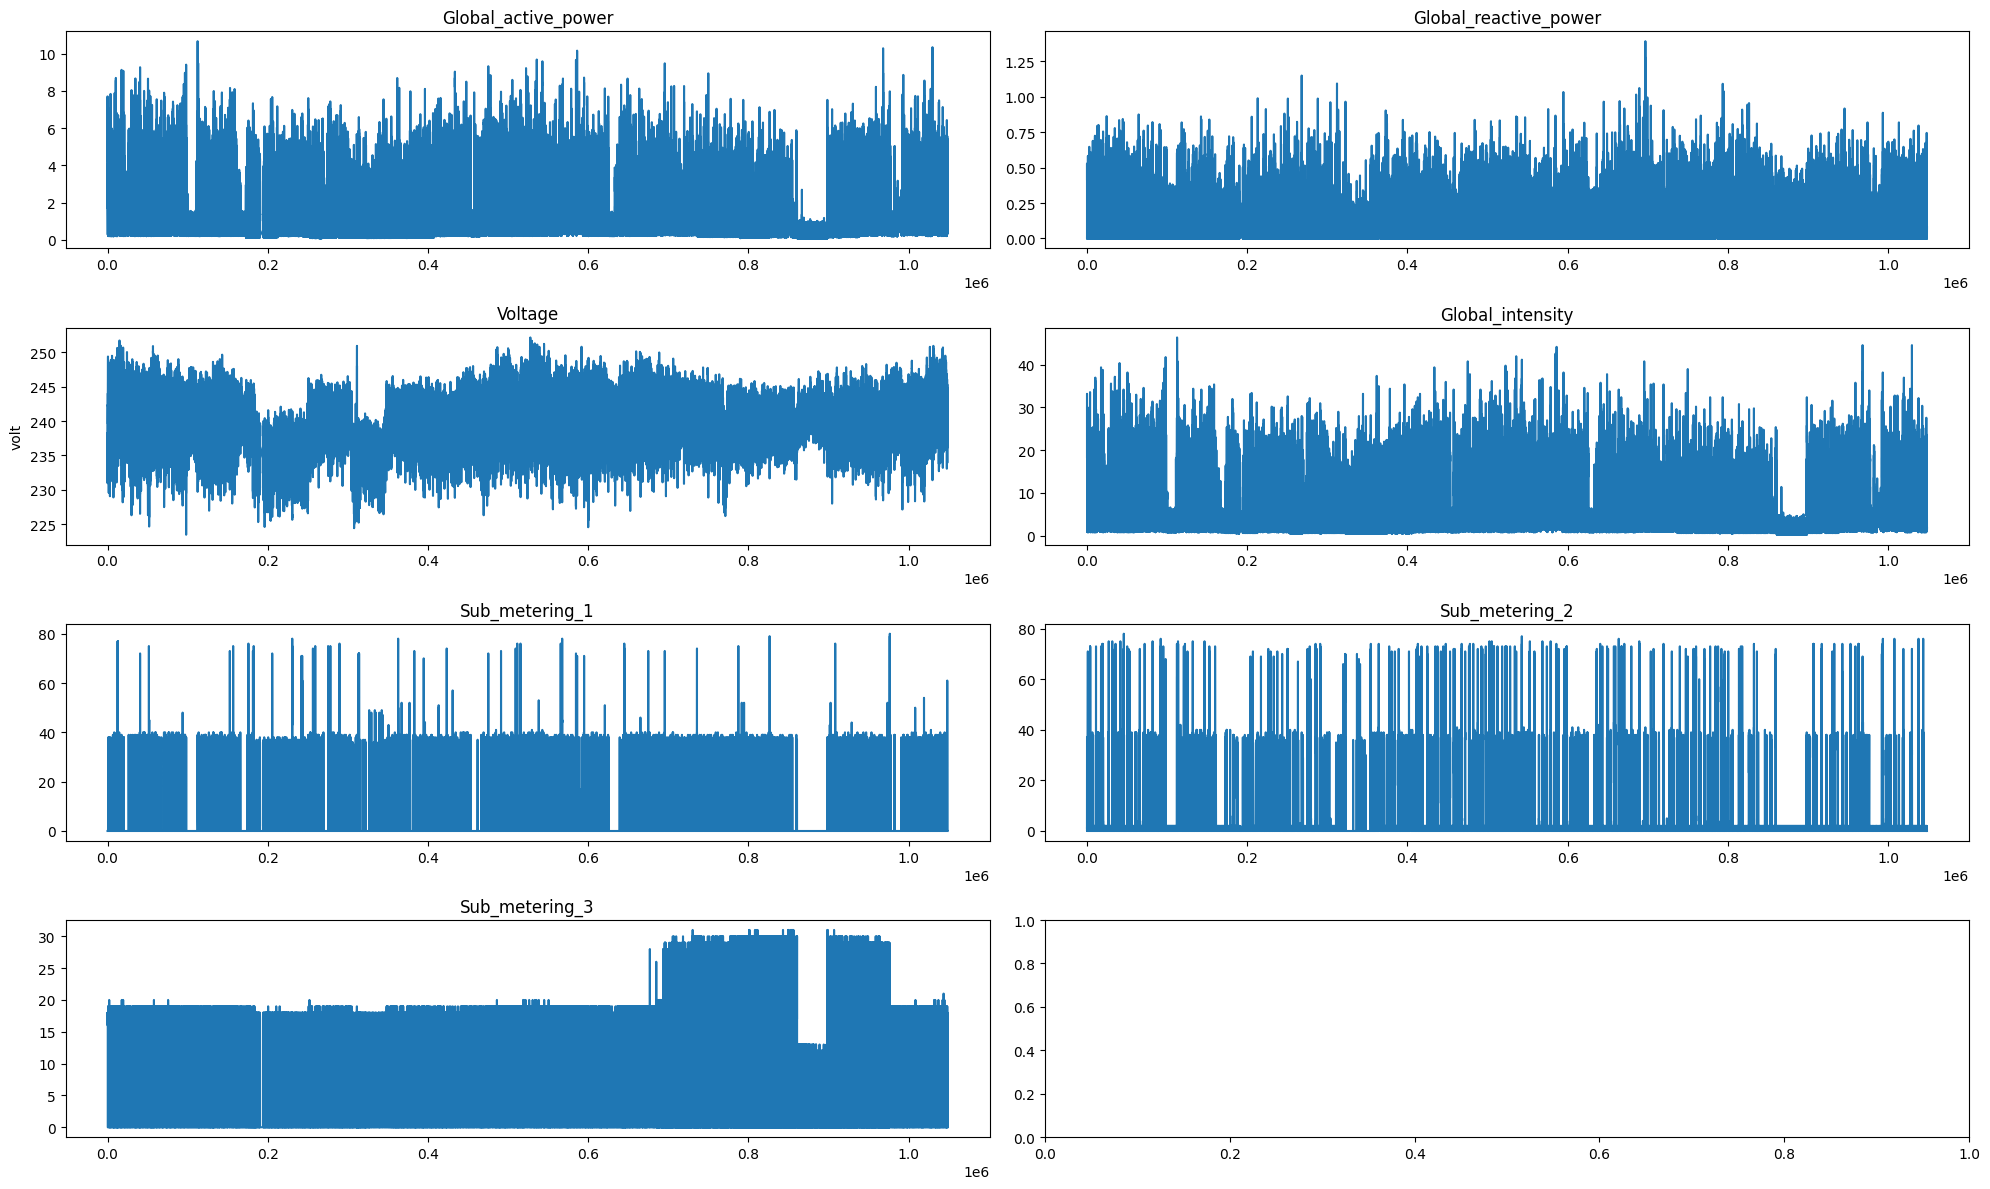

In [174]:
meters = {'power': 'kilowatt', 'Voltage': 'volt', 'intensity': 'ampere', 'metering': 'watt-hour'}
fig, axs = plt.subplots(4, 2, figsize=(20, 12))
for i, col in enumerate(df.columns):
    row = i // 2
    col_index = i % 2
    axs[row, col_index].plot(df.index, df[col])
    axs[row, col_index].set_title(col)
    axs[row, col_index].set_ylabel(meters.get(col.split('_')[0], ''))

plt.tight_layout()
plt.show()

<Axes: >

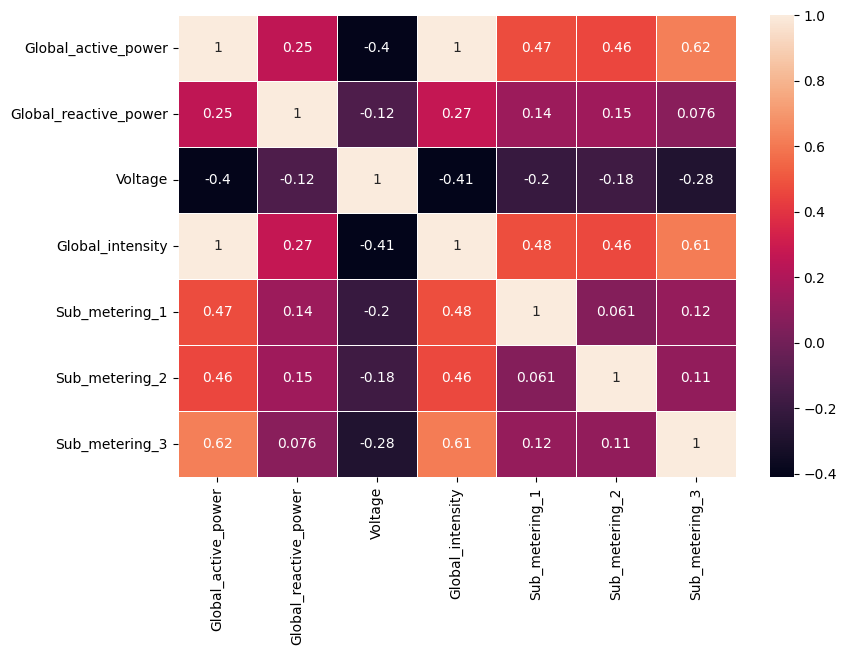

In [175]:
# Compute the correlation matrix
corr = df.corr()

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

ความสัมพันธ์ที่สำคัญ:

* Global_active_power และ Sub_metering_3 มีความสัมพันธ์เชิงบวก (0.62) แสดงว่าการใช้พลังงานที่ใช้งานจริงมีความเกี่ยวข้องกับการใช้พลังงานในหมวดหมู่ที่ 3 (เครื่องทำน้ำร้อนและเครื่องปรับอากาศ)
* Global_intensity ก็มีความสัมพันธ์เชิงบวกกับ Sub_metering_3 (0.61)
* Global_active_power และ Global_reactive_power มีความสัมพันธ์เชิงบวก (0.25) แต่ไม่สูงนัก

ข้อมูลนี้สามารถช่วยในการสร้างโมเดลการพยากรณ์การใช้พลังงาน เช่น การพยากรณ์ค่า Sub_metering_3 จากฟีเจอร์อื่น ๆ อย่าง Global_active_power และ Global_intensity ได้

**การจัดการค่าผิดปกติ(outliners)**

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

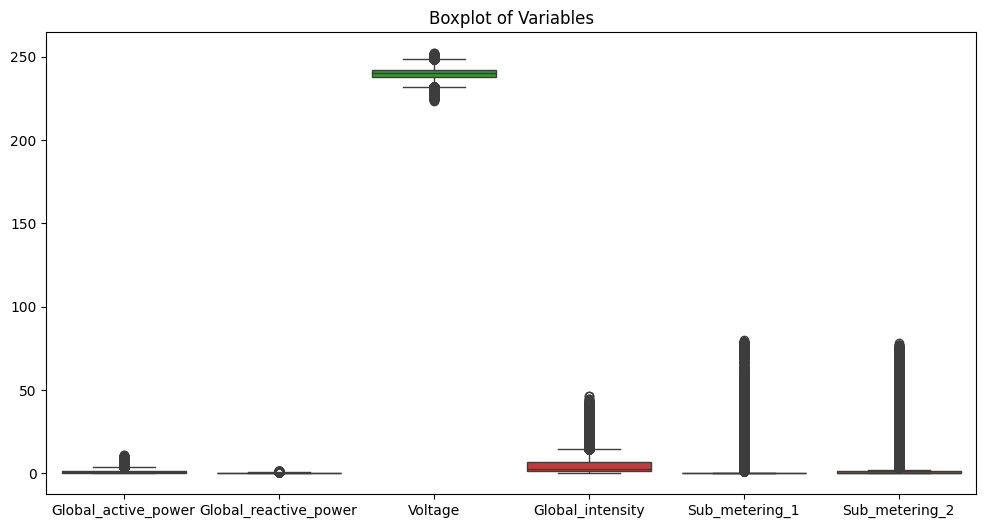

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

# แสดง boxplot สำหรับคอลัมน์ที่คุณต้องการตรวจสอบ
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2']])
plt.title('Boxplot of Variables')
plt.show()


**1.จัดการค่าผิดปกติ atribute (Voltage)**

In [177]:
# IQR
q1 = df.Voltage.quantile(.25)
q3 = df.Voltage.quantile(.75)
# q1, q3 = nppercentile(data4.unit_price, [25,75])

iqr= q3 - q1

upper = q3 + (1.5*iqr)
lower = q1 - (1.5*iqr)

print('Q1 = {}'.format(q1))
print('Q3 = {}'.format(q3))
print('IQR = {}'.format(iqr))
print('Upper = {:.2f}'.format(upper))
print('Lower = {}'.format(lower))

Q1 = 237.97
Q3 = 242.14
IQR = 4.1699999999999875
Upper = 248.39
Lower = 231.71500000000003


In [178]:
#นับจำนวนแถวที่คอลัมน์ sleep_rem เป็นค่าผิดปกติ
df[df.Voltage > upper].Voltage.count()

2233

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


<Axes: ylabel='Voltage'>

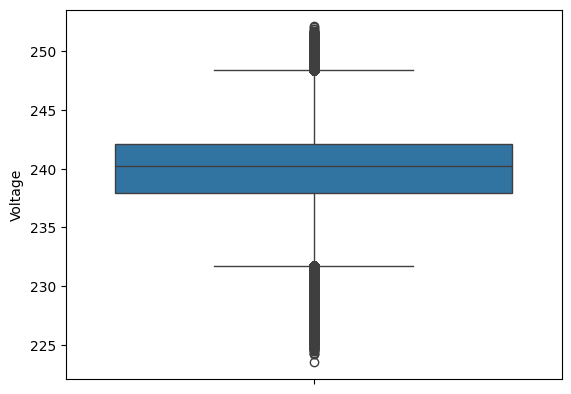

In [179]:
sns.boxplot(df.Voltage)

In [180]:
#ลบค่าผิดปกติเหนือขอบเขตบน
df.drop(df[df.Voltage> upper].index, inplace=True)

In [181]:
#เพื่อค่าผิดปกติใต้ขอบเขตล่าง
df['Voltage'][0] = -3

<ipython-input-181-f0c3ad3905f9>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Voltage'][0] = -3


In [182]:
#นับจำนวนแถวที่คอลัมน์ sleep_rem เป็นค่าผิดปกติ
df[df.Voltage > upper].Voltage.count()

0

In [183]:
df.to_csv('cleaned_household_power_consumption.csv', index=False)

# **3.การเตรียม Features (X) และ Target (y)**

In [184]:
X = df[['Global_reactive_power', 'Voltage', 'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']]
y = df['Global_active_power']

**เตรียมข้อมูล Train และ Test บันทึกเก็บลงไฟล์ csv**

In [185]:
# แบ่งข้อมูลเป็น Train และ Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้าง DataFrame สำหรับ Train และ Test
train_data = pd.DataFrame(X_train)
train_data['Global_active_power'] = y_train.values

test_data = pd.DataFrame(X_test)
test_data['Global_active_power'] = y_test.values

# บันทึก DataFrame ลงไฟล์ CSV
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)


# **4.วิธีดำเนินการ**

 เลือก 2 อัลกอริทึม คือ RandomForest และ XGB

In [186]:
#Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

พารามิเตอร์

n_estimators:

* ค่า: 100
* คือ จำนวนต้นไม้ใน Random Forest ที่จะสร้างในการฝึกโมเดล
* ผลกระทบ: ค่า 100 หมายความว่าจะสร้างต้นไม้ 100 ต้น ซึ่งจะช่วยเพิ่มความแม่นยำและลดความแปรปรวนของโมเดล หากมีค่าเกินไปอาจใช้เวลาฝึกนานขึ้น

max_depth:

* ค่า: 10
* คือ ความลึกสูงสุดของต้นไม้แต่ละต้น
* ผลกระทบ: จำกัดความลึกของต้นไม้ที่ 10 ช่วยป้องกันการ overfitting โดยทำให้โมเดลเรียนรู้ข้อมูลได้ในระดับที่เหมาะสม

random_state:

* ค่า: 42
* คือ ค่าคงที่สำหรับการสร้างเลขสุ่ม
* ผลกระทบ: การตั้งค่านี้ทำให้ผลลัพธ์สามารถทำซ้ำได้ หากคุณใช้ค่าคงที่เดียวกันในครั้งถัดไปจะได้ผลลัพธ์เหมือนเดิม

In [187]:
#Train XGB Model
xgb_model = XGBRegressor(n_estimators=250, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

พารามิเตอร์

n_estimators:

* ค่า: 250
* คือ จำนวนต้นไม้ที่สร้างใน XGBoost
* ผลกระทบ: ค่า 250 แสดงว่ามีการสร้างต้นไม้ 250 ต้น ซึ่งอาจทำให้โมเดลมีความแม่นยำสูงขึ้น แต่ก็อาจเพิ่มเวลาในการฝึก

max_depth:

* ค่า: 10
* คือ ความลึกสูงสุดของต้นไม้ใน XGBoost
* ผลกระทบ: ความลึกที่ 10 จะช่วยในการจำกัดความซับซ้อนของโมเดลและป้องกันการ overfitting

random_state:

* ค่า: 42
* คือ ค่าคงที่สำหรับการสร้างเลขสุ่ม
* ผลกระทบ: การใช้ค่าคงที่นี้ทำให้การฝึกโมเดลสามารถทำซ้ำได้ โดยให้ผลลัพธ์เหมือนเดิมในแต่ละครั้งที่รัน

In [188]:
#Predict and Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [189]:
#Predict and Evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# **5.ผลการทดลอง**

In [190]:
# Save Evaluation Results
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'MSE': [mse_rf, mse_xgb]
})
results.to_csv('model_evaluation_results.csv', index=False)

print(f"Random Forest MSE: {mse_rf}, R^2: {r2_rf}")
print(f"XGBoost MSE: {mse_xgb}, R^2: {r2_xgb}")

Random Forest MSE: 0.0012392898579641752, R^2: 0.9990352406738656
XGBoost MSE: 0.0009949085366857565, R^2: 0.999225486044891


In [191]:
# Save Models
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(xgb_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

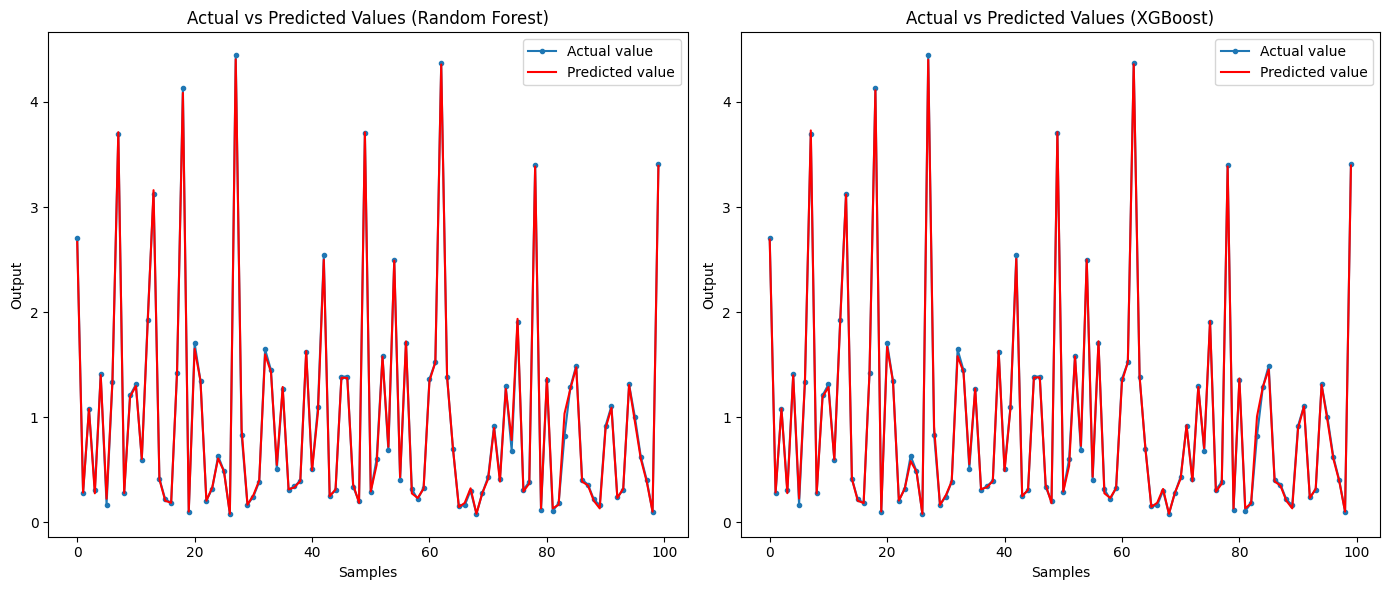

In [192]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))

# Subplot สำหรับ Random Forest
plt.subplot(1, 2, 1)
x = np.arange(100)  # แกน x สำหรับ 100 ตัวอย่างแรก
plt.plot(x, y_test[:100], marker='.', label='Actual value')
plt.plot(x, y_pred_rf[:100], 'r', label='Predicted value')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.legend()

# Subplot สำหรับ XGBoost
plt.subplot(1, 2, 2)
plt.plot(x, y_test[:100], marker='.', label='Actual value')
plt.plot(x, y_pred_xgb[:100], 'r', label='Predicted value')
plt.xlabel('Samples')
plt.ylabel('Output')
plt.title('Actual vs Predicted Values (XGBoost)')
plt.legend()

plt.tight_layout()
#plt.legend(fontsize=15)
plt.show()